# Tutorial 04: Power Spectral Density Analysis

This tutorial demonstrates power spectral density (PSD) analysis for radio astronomy observations, showing how satellite interference affects the frequency domain characteristics of the received signal.

The tutorial models a wider bandwidth observation with multiple frequency channels to visualize the spectral characteristics of both astronomical sources and satellite interference.

## Learning Objectives:
- Understand power spectral density analysis in radio astronomy
- Learn to model frequency-dependent satellite transmission patterns
- Explore spectral interference characteristics across frequency channels
- Analyze frequency-domain effects of satellite interference
- Create spectrograms and frequency slice visualizations
- Compare transmission profiles with observed interference patterns

## Prerequisites:
- Completion of Tutorial 01: Basic Radio Astronomy Observation
- Completion of Tutorial 02: Satellite Interference Analysis
- Understanding of frequency domain analysis and spectral concepts

## Output Files:
- `04_satellite_transmission_profile.png`: Satellite transmission profile across frequency channels
- `04_power_spectral_density.png`: PSD spectrogram showing interference over time and frequency
- `04_frequency_slice.png`: Frequency slice analysis at a specific time


## Import Required Libraries

First, we need to import the necessary libraries and set up the Python path to access the RSC-SIM modules.


In [1]:
import sys
import os
import time
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

# Add the src/ path
sys.path.insert(0, os.path.join(os.getcwd(), '..', 'src'))

# Import RSC-SIM modules
from radio_types import Observation, Constellation, Trajectory, Instrument
from astro_mdl import power_to_temperature, temperature_to_power
from sat_mdl import sat_link_budget_vectorized
from obs_mdl import model_observed_temp

# Import shared utilities
from shared.config import STANDARD_FIGURE_SIZE, CENTER_FREQUENCY
from shared.instrument_setup import (
    setup_psd_instrument,
    setup_frequency_dependent_satellite
)
from shared.sky_models import create_sky_model
from shared.plotting_utils import plot_psd_spectrogram, setup_plotting

# Set up plotting
setup_plotting()

print("✓ All libraries imported successfully")


✓ All libraries imported successfully


## Define Helper Functions

We'll define helper functions for creating frequency-dependent transmission profiles.


In [2]:
def create_frequency_dependent_transmission_profile(num_channels):
    """
    Create a frequency-dependent transmission profile for satellites.

    This simulates realistic satellite transmission patterns with:
    - Reduced power at band edges
    - Notches for interference avoidance
    - Peak transmission at center frequency

    Args:
        num_channels: Number of frequency channels

    Returns:
        array: Transmission profile (0-1 scale)
    """
    tmt_profile = np.ones(num_channels)

    # Reduce power at band edges (first and last 10% of channels)
    edge_reduction = num_channels // 10
    tmt_profile[:edge_reduction] = 0.0
    tmt_profile[-edge_reduction:] = 0.0

    # Create interference avoidance notch in center
    notch_width = num_channels // 10
    center_start = num_channels // 2 - notch_width // 2
    center_end = num_channels // 2 + notch_width // 2
    tmt_profile[center_start:center_end] = 0.0

    # Ensure center frequency has full power
    tmt_profile[num_channels // 2] = 1.0

    return tmt_profile

print("✓ Helper functions defined successfully")


✓ Helper functions defined successfully


## Step 1: Set Up Data Paths and Parameters

We'll start by setting up the data file paths and observation parameters for our PSD analysis.


In [3]:
print("=== Power Spectral Density Analysis ===")
print("Modeling frequency-domain characteristics of radio observations")
print()

# Get path to data files (located in tutorial/data/)
script_dir = os.path.dirname(os.path.abspath('__file__'))
data_dir = os.path.join(os.path.dirname(script_dir), "tutorial", "data")

# Time window for analysis
start_window = "2025-02-18T15:00:00.000"
stop_window = "2025-02-18T15:45:00.000"

# Replace colons with underscores for filename
start_window_str = start_window.replace(":", "_")
stop_window_str = stop_window.replace(":", "_")

print(f"Data directory: {data_dir}")
print(f"Time window: {start_window} to {stop_window}")
print(f"Filename format: casA_trajectory_Westford_{start_window_str}_{stop_window_str}.arrow")


=== Power Spectral Density Analysis ===
Modeling frequency-domain characteristics of radio observations

Data directory: c:\NatHaz\DK\CRC\SpectrumX\cursor_test\RSC-SIM\tutorial\data
Time window: 2025-02-18T15:00:00.000 to 2025-02-18T15:45:00.000
Filename format: casA_trajectory_Westford_2025-02-18T15_00_00.000_2025-02-18T15_45_00.000.arrow


## Step 2: Load Source Trajectory

Now we'll load the trajectory data for our astronomical source (Cas A - Cassiopeia A).


In [4]:
# Load source trajectory
file_traj_obj_path = os.path.join(
    data_dir,
    f"casA_trajectory_Westford_{start_window_str}_{stop_window_str}.arrow"
)

print(f"Loading source trajectory from: {file_traj_obj_path}")
traj_src = Trajectory.from_file(
    file_traj_obj_path,
    time_tag='time_stamps',
    elevation_tag='altitudes',
    azimuth_tag='azimuths',
    distance_tag='distances'
)
print("✓ Source trajectory loaded")
print(f"  - Time range: {traj_src.get_traj()['times'].min()} to {traj_src.get_traj()['times'].max()}")


Loading source trajectory from: c:\NatHaz\DK\CRC\SpectrumX\cursor_test\RSC-SIM\tutorial\data\casA_trajectory_Westford_2025-02-18T15_00_00.000_2025-02-18T15_45_00.000.arrow
✓ Source trajectory loaded
  - Time range: 2025-02-18 15:00:00 to 2025-02-18 15:45:00


## Step 3: Define Observation Parameters

We'll set up the observation parameters including time windows and pointing offsets.


In [5]:
# Define observation parameters
dateformat = "%Y-%m-%dT%H:%M:%S.%f"
start_obs = datetime.strptime("2025-02-18T15:30:00.000", dateformat)
stop_obs = datetime.strptime("2025-02-18T15:40:00.000", dateformat)

# Create pointing trajectory with offset
offset_angles = (-40, 0.)  # (az,el) in degrees
time_off_src = start_obs
time_on_src = time_off_src + timedelta(minutes=5)

# Copy and modify trajectory
traj_obj = Trajectory(traj_src.traj.copy())
mask = (traj_obj.traj['times'] >= time_off_src) & (traj_obj.traj['times'] <= time_on_src)
traj_obj.traj.loc[mask, 'azimuths'] += offset_angles[0]
traj_obj.traj.loc[mask, 'elevations'] += offset_angles[1]

# Filter points below 5deg elevation
filt_el = ('elevations', lambda e: e > 5.)

print("✓ Observation parameters defined")
print(f"  - Observation period: {start_obs} to {stop_obs}")
print(f"  - OFF source: {time_off_src} to {time_on_src}")
print(f"  - ON source: {time_on_src} to {stop_obs}")
print(f"  - Offset angles: {offset_angles[0]}° azimuth, {offset_angles[1]}° elevation")
print(f"  - Minimum elevation: 5°")


✓ Observation parameters defined
  - Observation period: 2025-02-18 15:30:00 to 2025-02-18 15:40:00
  - OFF source: 2025-02-18 15:30:00 to 2025-02-18 15:35:00
  - ON source: 2025-02-18 15:35:00 to 2025-02-18 15:40:00
  - Offset angles: -40° azimuth, 0.0° elevation
  - Minimum elevation: 5°


## Step 4: Create High-Resolution Instrument

We'll create a high-resolution instrument specifically designed for PSD analysis with multiple frequency channels.


In [6]:
# Create high-resolution instrument for PSD analysis
print("Creating high-resolution instrument for PSD analysis...")

# Instrument parameters for PSD analysis
new_bw = 30e6  # 30 MHz bandwidth
new_freq_chan = 164  # 164 frequency channels

# Create telescope instrument for PSD analysis
westford_freqs = setup_psd_instrument()

# Create observation
observ_freqs = Observation.from_dates(
    start_obs, stop_obs, traj_obj, westford_freqs,
    filt_funcs=(filt_el,)
)

print("✓ High-resolution instrument created")
print(f"  - Bandwidth: {new_bw/1e6:.0f} MHz")
print(f"  - Frequency channels: {new_freq_chan}")
print(f"  - Channel bandwidth: {new_bw/new_freq_chan/1e3:.1f} kHz")
print(f"  - Center frequency: {westford_freqs.get_center_freq()/1e9:.3f} GHz")


Creating high-resolution instrument for PSD analysis...
This power_pattern_from_cut_file function assumes Daniel Sheen generated files
✓ High-resolution instrument created
  - Bandwidth: 30 MHz
  - Frequency channels: 164
  - Channel bandwidth: 182.9 kHz
  - Center frequency: 11.325 GHz


## Step 5: Create Sky Model

We'll create the sky temperature model that includes all the components we want to observe.


In [7]:
# Create sky model
sky_mdl = create_sky_model(observ_freqs)
print("✓ Sky model created")


✓ Sky model created


## Step 6: Create Frequency-Dependent Transmission Profile

We'll create a realistic satellite transmission profile that varies across frequency channels, simulating real-world satellite behavior.


In [8]:
# Create satellite constellation with frequency-dependent transmission
print("Setting up satellite constellation with frequency-dependent transmission...")

# Create frequency-dependent transmission profile
tmt_profile = create_frequency_dependent_transmission_profile(new_freq_chan)
freq_bins = westford_freqs.get_center_freq_chans()

print("✓ Frequency-dependent transmission profile created")
print(f"  - Profile features:")
print(f"    * Edge reduction: First and last 10% of channels set to 0")
print(f"    * Center notch: 10% of channels around center set to 0")
print(f"    * Peak transmission: Center frequency at full power")
print(f"  - Frequency range: {freq_bins[0]/1e9:.3f} to {freq_bins[-1]/1e9:.3f} GHz")


Setting up satellite constellation with frequency-dependent transmission...
✓ Frequency-dependent transmission profile created
  - Profile features:
    * Edge reduction: First and last 10% of channels set to 0
    * Center notch: 10% of channels around center set to 0
    * Peak transmission: Center frequency at full power
  - Frequency range: 11.310 to 11.340 GHz


## Step 7: Visualize Transmission Profile

Let's plot the satellite transmission profile to understand how power varies across frequency channels.


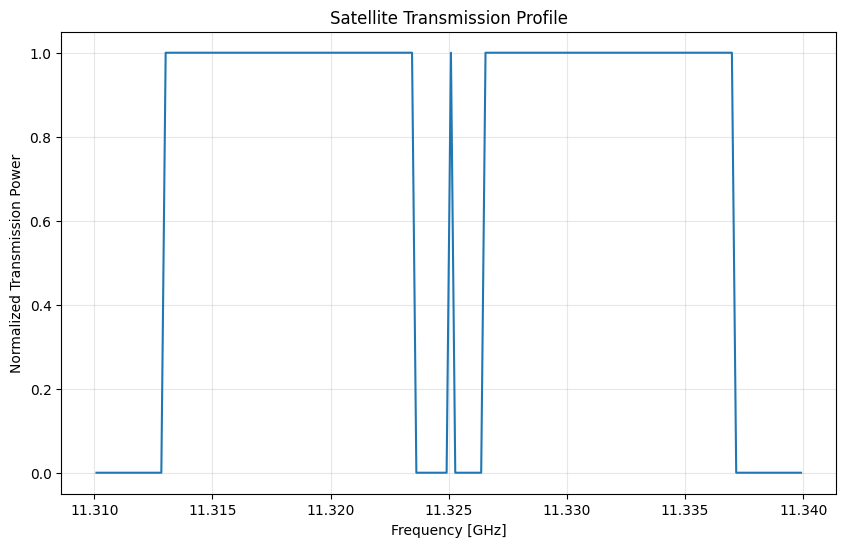

✓ Satellite transmission profile saved as '04_satellite_transmission_profile.png'


In [9]:
# Plot transmission profile
fig, ax = plt.subplots(figsize=STANDARD_FIGURE_SIZE)
ax.plot(freq_bins / 1e9, tmt_profile)
ax.set_xlabel("Frequency [GHz]")
ax.set_ylabel("Normalized Transmission Power")
ax.set_title("Satellite Transmission Profile")
ax.grid(True)
plt.savefig("04_satellite_transmission_profile.png", dpi=300, bbox_inches='tight')
plt.show()
print("✓ Satellite transmission profile saved as '04_satellite_transmission_profile.png'")


## Step 8: Create Satellite Instrument with Frequency-Dependent Transmission

We'll create a custom satellite instrument that uses our frequency-dependent transmission profile.


In [10]:
# Create satellite instrument with frequency-dependent transmission
def transmit_temp_freqs(tim, freq):
    ind_freq = np.argmin(np.abs(freq_bins - freq))
    transmit_pow = -15 + 10 * np.log10(300)  # dBW
    return tmt_profile[ind_freq] * power_to_temperature(10**(transmit_pow/10), 1.0)

# Create custom satellite instrument with our frequency-dependent transmission
sat_ant = setup_frequency_dependent_satellite().get_antenna()
sat_transmit_freqs = Instrument(
    sat_ant,
    0.0,  # physical temperature
    CENTER_FREQUENCY,
    new_bw,
    transmit_temp_freqs,
    new_freq_chan,
    []
)

print("✓ Satellite instrument with frequency-dependent transmission created")
print(f"  - Transmit power: -15 dBW + 10*log10(300) = {(-15 + 10 * np.log10(300)):.1f} dBW")
print(f"  - Frequency-dependent transmission: Enabled")
print(f"  - Antenna pattern: ITU standard")


This power_pattern_from_cut_file function assumes Daniel Sheen generated files
✓ Satellite instrument with frequency-dependent transmission created
  - Transmit power: -15 dBW + 10*log10(300) = 9.8 dBW
  - Frequency-dependent transmission: Enabled
  - Antenna pattern: ITU standard


## Step 9: Load Satellite Constellation

We'll load the satellite constellation data and apply our frequency-dependent transmission model.


In [11]:
# Load satellite trajectories
file_traj_sats_path = os.path.join(
    data_dir,
    f"Starlink_trajectory_Westford_{start_window_str}_{stop_window_str}.arrow"
)

# Filter satellites
filt_name = ('sat', lambda s: ~s.str.contains('DTC'))
filt_el = ('elevations', lambda e: e > 20)

# Create constellation
starlink_constellation_freqs = Constellation.from_file(
    file_traj_sats_path, observ_freqs, sat_transmit_freqs,
    sat_link_budget_vectorized,
    name_tag='sat',
    time_tag='timestamp',
    elevation_tag='elevations',
    azimuth_tag='azimuths',
    distance_tag='ranges_westford',
    filt_funcs=(filt_name, filt_el)
)

print("✓ Satellite constellation loaded")
print(f"  - Number of satellites: {len(starlink_constellation_freqs.sats['sat'].unique())}")
print(f"  - Time range: {starlink_constellation_freqs.sats['times'].min()} to {starlink_constellation_freqs.sats['times'].max()}")
print(f"  - Filters applied: No DTC satellites, elevation > 20°")


✓ Satellite constellation loaded
  - Number of satellites: 201
  - Time range: 2025-02-18 15:30:00 to 2025-02-18 15:40:00
  - Filters applied: No DTC satellites, elevation > 20°


## Step 10: Compute Power Spectral Density

Now we'll compute the power spectral density results. This may take several minutes due to the high frequency resolution.


In [ ]:
# Compute PSD results
print("Computing power spectral density...")

start_time = time.time()
result_freqs = model_observed_temp(
    observ_freqs, sky_mdl, starlink_constellation_freqs
)
end_time = time.time()

execution_time = end_time - start_time
print(f"PSD computation completed in {execution_time:.2f} seconds")

# Get time and frequency data
time_samples = observ_freqs.get_time_stamps()
freq_bins = westford_freqs.get_center_freq_chans()

# Convert temperature to power (use same bandwidth as original: 1 kHz)
# The original code uses bw/freq_chan = 1e3/1 = 1000 Hz for PSD calculation
plot_psd = temperature_to_power(result_freqs, 1e3)

print("✓ PSD computation completed")
print(f"  - Result shape: {result_freqs.shape}")
print(f"  - Time samples: {len(time_samples)}")
print(f"  - Frequency channels: {len(freq_bins)}")
print(f"  - Computation time: {execution_time:.2f} seconds")


Computing power spectral density...
Note: This may take several minutes due to high frequency resolution...
PSD computation completed in 10.75 seconds
✓ PSD computation completed
  - Result shape: (601, 1, 164)
  - Time samples: 601
  - Frequency channels: 164
  - Computation time: 10.75 seconds


## Step 11: Create PSD Spectrogram

We'll create a spectrogram visualization showing how power varies across both time and frequency.


Creating PSD spectrogram...


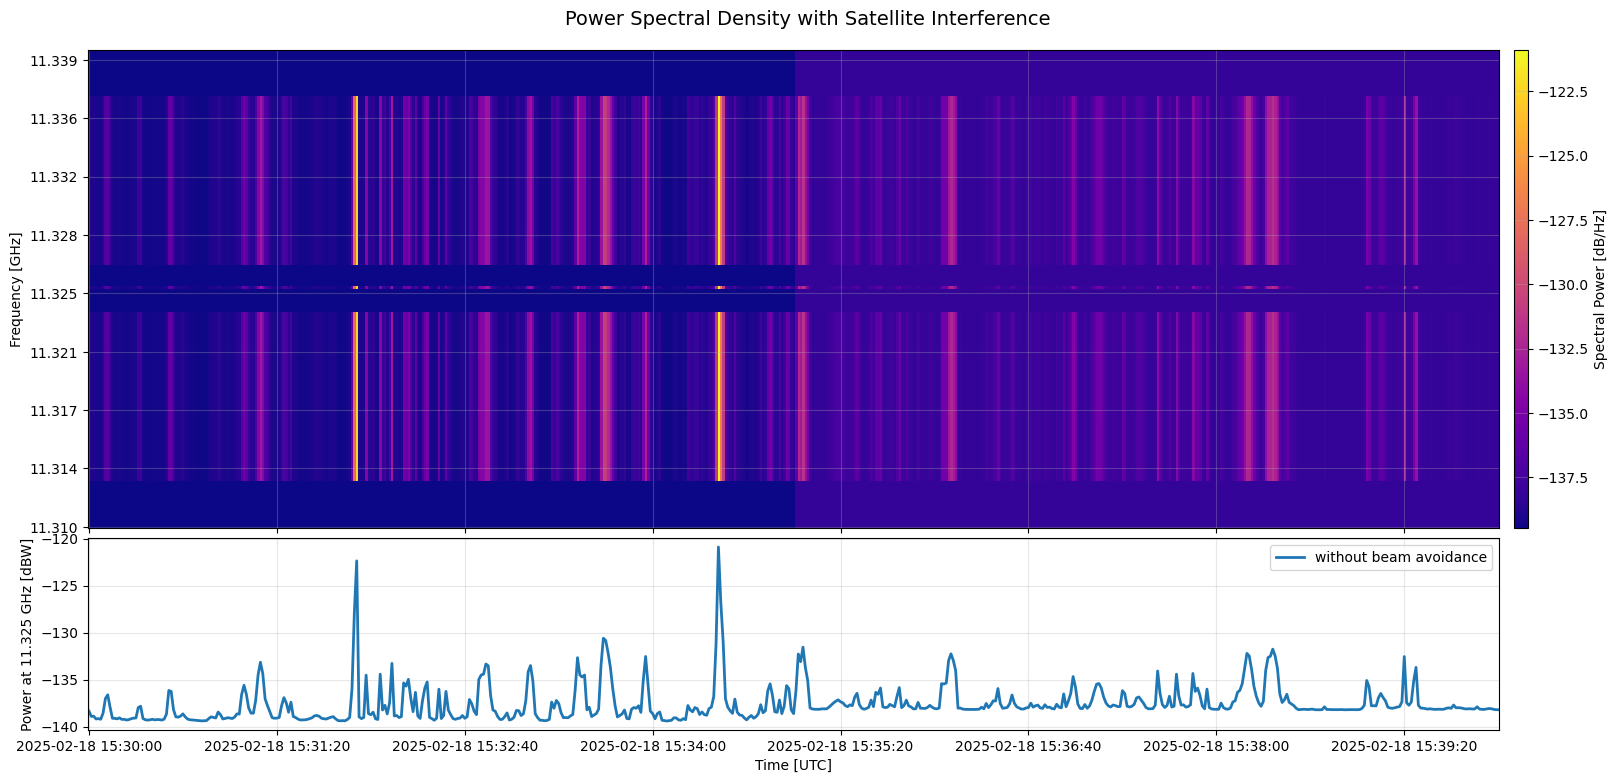

✓ PSD spectrogram saved as '04_power_spectral_density.png'


In [13]:
# Create PSD spectrogram plot
print("Creating PSD spectrogram...")
fig, axes, psd_imshow = plot_psd_spectrogram(
    time_samples, freq_bins, plot_psd,
    title="Power Spectral Density with Satellite Interference",
    colormap="plasma"  # Use plasma colormap to match original plot
)

plt.savefig("04_power_spectral_density.png", dpi=300, bbox_inches='tight')
plt.show()
print("✓ PSD spectrogram saved as '04_power_spectral_density.png'")


## Step 12: Frequency Slice Analysis

Let's analyze the frequency characteristics at a specific time to understand the spectral structure.


Creating frequency slice analysis...


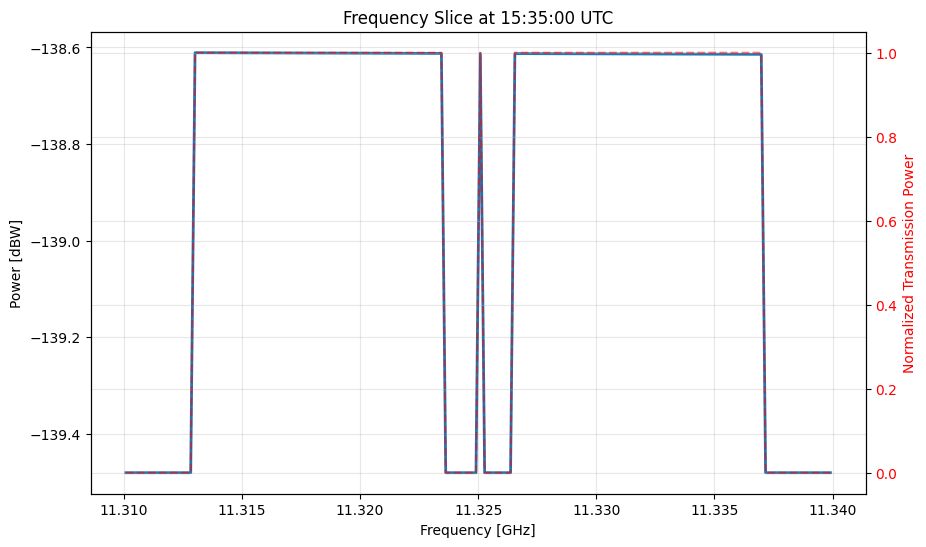

✓ Frequency slice analysis saved as '04_frequency_slice.png'


In [14]:
# Frequency slice analysis
print("Creating frequency slice analysis...")

# Select a time slice for frequency analysis
time_idx = len(time_samples) // 2  # Middle of observation
selected_time = time_samples.iloc[time_idx]

fig, ax = plt.subplots(figsize=STANDARD_FIGURE_SIZE)

# Plot power vs frequency at selected time
freq_power = plot_psd[time_idx, 0, :]
ax.plot(freq_bins / 1e9, 10 * np.log10(freq_power), linewidth=2)

ax.set_xlabel("Frequency [GHz]")
ax.set_ylabel("Power [dBW]")
ax.set_title(f"Frequency Slice at {selected_time.strftime('%H:%M:%S')} UTC")
ax.grid(True)

# Add transmission profile for reference
ax_twin = ax.twinx()
ax_twin.plot(freq_bins / 1e9, tmt_profile, 'r--', alpha=0.5, label="Satellite TX Profile")
ax_twin.set_ylabel("Normalized Transmission Power", color='r')
ax_twin.tick_params(axis='y', labelcolor='r')

plt.savefig("04_frequency_slice.png", dpi=300, bbox_inches='tight')
plt.show()
print("✓ Frequency slice analysis saved as '04_frequency_slice.png'")


## Step 13: Analysis Summary

Let's generate a comprehensive summary of our PSD analysis results.


In [15]:
# Summary statistics
print("\n=== PSD Analysis Summary ===")
print(f"Observation duration: {stop_obs - start_obs}")
print(f"Frequency range: {freq_bins[0]/1e9:.3f} - {freq_bins[-1]/1e9:.3f} GHz")
print(f"Frequency resolution: {(freq_bins[1] - freq_bins[0])/1e6:.1f} MHz")
print(f"Time resolution: {(time_samples.iloc[1] - time_samples.iloc[0]).total_seconds():.1f} seconds")
print(f"Total frequency channels: {new_freq_chan}")
print(f"Total time samples: {len(time_samples)}")

# Power statistics
max_power = np.max(10 * np.log10(plot_psd))
min_power = np.min(10 * np.log10(plot_psd))
mean_power = np.mean(10 * np.log10(plot_psd))

print(f"Power range: {min_power:.1f} to {max_power:.1f} dBW")
print(f"Mean power: {mean_power:.1f} dBW")

print("\nPSD analysis completed successfully!")
print("Generated files:")
print("- 04_satellite_transmission_profile.png")
print("- 04_power_spectral_density.png")
print("- 04_frequency_slice.png")
print("\nNote: Four-scenario comparison plot is now available in 02_satellite_interference.py")



=== PSD Analysis Summary ===
Observation duration: 0:10:00
Frequency range: 11.310 - 11.340 GHz
Frequency resolution: 0.2 MHz
Time resolution: 1.0 seconds
Total frequency channels: 164
Total time samples: 601
Power range: -139.5 to -120.9 dBW
Mean power: -137.9 dBW

PSD analysis completed successfully!
Generated files:
- 04_satellite_transmission_profile.png
- 04_power_spectral_density.png
- 04_frequency_slice.png

Note: Four-scenario comparison plot is now available in 02_satellite_interference.py


## Summary

Congratulations! You have successfully completed Tutorial 04. 
